In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
import pickle
import itertools

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [2]:
def seperateCNN():
    input1 = keras.Input(shape=(10, 12, 1))
    input2 = keras.Input(shape=(46, 12, 1))

    x = layers.Conv2D(filters=16, kernel_size=(2, 12))(input1)  # 9
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Conv2D(filters=32, kernel_size=(2, 1))(x)    # 8
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(x)  # 4
    x = layers.Flatten()(x)
    x = keras.Model(inputs=input1, outputs=x)

    y = layers.Conv2D(filters=16, kernel_size=(15, 12))(input2)     # 32
    y = layers.BatchNormalization()(y)
    y = keras.activations.relu(y)
    y = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(y)  # 16
    y = layers.Conv2D(filters=32,kernel_size=(9,1))(y)    # 8
    y = layers.BatchNormalization()(y)
    y = keras.activations.relu(y)
    y = layers.MaxPool2D(pool_size=(2, 1),strides=(2,1))(y)  # 4
    y = layers.Flatten()(y)
    y = keras.Model(inputs=input2,outputs=y)

    combined = layers.concatenate([x.output,y.output])
    z = layers.Dense(128,activation='relu')(combined)
    z = layers.Dropout(0.2)(z)
    z = layers.Dense(1,activation='sigmoid')(z)

    model = keras.Model(inputs=[input1,input2],outputs=z)
    return model

def pull_peptide_aaindex(dataset):
    result = np.empty([len(dataset),10,12,1])
    for i in range(len(dataset)):
        result[i,:,:,:] = dataset[i][0]
    return result


def pull_hla_aaindex(dataset):
    result = np.empty([len(dataset),46,12,1])
    for i in range(len(dataset)):
        result[i,:,:,:] = dataset[i][1]
    return result


def pull_label_aaindex(dataset):
    col = [item[2] for item in dataset]
    result = [0 if item == 'Negative' else 1 for item in col]
    result = np.expand_dims(np.array(result),axis=1)
    return result

def pull_label_aaindex(dataset):
    result = np.empty([len(dataset),1])
    for i in range(len(dataset)):
        result[i,:] = dataset[i][2]
    return result

def aaindex(peptide,after_pca):

    amino = 'ARNDCQEGHILKMFPSTWYV-'
    matrix = np.transpose(after_pca)   # [12,21]
    encoded = np.empty([len(peptide), 12])  # (seq_len,12)
    for i in range(len(peptide)):
        query = peptide[i]
        if query == 'X': query = '-'
        query = query.upper()
        encoded[i, :] = matrix[:, amino.index(query)]

    return encoded

# def aaindex(peptide,after_pca):
#     amino = 'ARNDCQEGHILKMFPSTWYV-'
#     encoded = np.empty([len(peptide),21])
#     onehot = np.identity(21)
#     for i in range(len(peptide)):
#         query = peptide[i]
#         if query == 'X': query = '-'
#         query = query.upper()
#         encoded[i,:] = onehot[:,amino.index(query)]
#     return encoded

def peptide_data_aaindex(peptide,after_pca):   # return numpy array [10,12,1]
    length = len(peptide)
    if length == 10:
        encode = aaindex(peptide,after_pca)
    elif length == 9:
        peptide = peptide[:5] + '-' + peptide[5:]
        encode = aaindex(peptide,after_pca)
    encode = encode.reshape(encode.shape[0], encode.shape[1], -1)
    return encode

def dict_inventory(inventory):
    dicA, dicB, dicC = {}, {}, {}
    dic = {'A': dicA, 'B': dicB, 'C': dicC}

    for hla in inventory:
        type_ = hla[4]  # A,B,C
        first2 = hla[6:8]  # 01
        last2 = hla[8:]  # 01
        try:
            dic[type_][first2].append(last2)
        except KeyError:
            dic[type_][first2] = []
            dic[type_][first2].append(last2)

    return dic


def rescue_unknown_hla(hla, dic_inventory):
    type_ = hla[4]
    first2 = hla[6:8]
    last2 = hla[8:]
    big_category = dic_inventory[type_]
    #print(hla)
    if not big_category.get(first2) == None:
        small_category = big_category.get(first2)
        distance = [abs(int(last2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(first2) + str(optimal)
    else:
        small_category = list(big_category.keys())
        distance = [abs(int(first2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(optimal) + str(big_category[optimal][0])






def hla_data_aaindex(hla_dic,hla_type,after_pca):    # return numpy array [34,12,1]
    try:
        seq = hla_dic[hla_type]
    except KeyError:
        hla_type = rescue_unknown_hla(hla_type,dic_inventory)
        seq = hla_dic[hla_type]
    encode = aaindex(seq,after_pca)
    encode = encode.reshape(encode.shape[0], encode.shape[1], -1)
    return encode

def construct_aaindex(ori,hla_dic,after_pca):
    series = []
    for i in range(ori.shape[0]):
        peptide = ori['peptide'].iloc[i]
        hla_type = ori['HLA'].iloc[i]
        immuno = np.array(ori['immunogenicity'].iloc[i]).reshape(1,-1)   # [1,1]

        encode_pep = peptide_data_aaindex(peptide,after_pca)    # [10,12]

        encode_hla = hla_data_aaindex(hla_dic,hla_type,after_pca)   # [46,12]
        series.append((encode_pep, encode_hla, immuno))
    return series

def hla_df_to_dic(hla):
    dic = {}
    for i in range(hla.shape[0]):
        col1 = hla['HLA'].iloc[i]  # HLA allele
        col2 = hla['pseudo'].iloc[i]  # pseudo sequence
        dic[col1] = col2
    return dic

def retain_910(ori):
    cond = []
    for i in range(ori.shape[0]):
        peptide = ori['peptide'].iloc[i]
        if len(peptide) == 9 or len(peptide) == 10:
            cond.append(True)
        else:
            cond.append(False)
    data = ori.loc[cond]
    data = data.set_index(pd.Index(np.arange(data.shape[0])))
    return data

In [40]:
after_pca = np.loadtxt('../data/after_pca.txt')
ori = pd.read_csv('../data/remove0123_sample100.csv')
ori = ori.sample(frac=1,replace=False).set_index(pd.Index(np.arange(ori.shape[0])))
hla = pd.read_csv('../data/hla2paratopeTable_aligned.txt',sep='\t')
hla_dic = hla_df_to_dic(hla)
inventory = list(hla_dic.keys())
dic_inventory = dict_inventory(inventory)
dataset = construct_aaindex(ori,hla_dic,after_pca)

In [41]:
cnn_model = seperateCNN()
cnn_model.load_weights('../data/models/cnn_model_331_3_7/')

In [42]:
new_dataset = []
for item in dataset:
    if item[2] != 'Negative':
        new_dataset.append(item)

In [36]:
# let's boostrap 100 times, see if the rank holds
n = 100
position_rank = np.empty([n, 9])
for m in range(n):
    ind = np.random.choice(np.arange(len(new_dataset)),2000)  # bootstrap 2000 positive samples
    sample = [new_dataset[i] for i in ind]  # get samples
    input1 = pull_peptide_aaindex(sample)
    input2 = pull_hla_aaindex(sample)
    pred_ori = cnn_model([input1,input2]).numpy().mean()  # original prediction
    array = []  # store all the importance, based on the decrease when eliminating each position
    for i in range(10):
        if i != 5:
            input1[:,i,:,:] = 0
            importance = pred_ori - cnn_model([input1,input2]).numpy().mean()
            array.append(importance)
            input1 = pull_peptide_aaindex(sample)
            input2 = pull_hla_aaindex(sample)
    ranking = np.argsort(array) + 1   # ascending order
    tmp = []
    for i in range(9):
        tmp.append(list(ranking).index(i+1))
    position_rank[m,:] = tmp

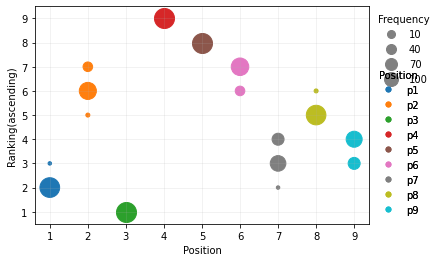

In [37]:
# start to plot
cmap = mpl.cm.get_cmap('tab10')
delim = np.linspace(0,1,9)
colors = [mpl.colors.rgb2hex(cmap(i)[:3]) for i in delim]
from collections import Counter
fig,ax = plt.subplots()
for i in np.arange(9):
    y = list(Counter(position_rank[:,i]+1).keys())
    s = list(Counter(position_rank[:,i]+1).values())
    ax.scatter([i for n in range(len(y))],y, s=[m*4 for m in s],c=colors[i])
ax.set_ylim(0.5,9.5)
ax.set_yticks(np.arange(9)+1)
ax.set_xticks(np.arange(9))
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9'])
ax.set_xlabel('Position')
ax.set_ylabel('Ranking(ascending)')
ax.grid(True,alpha=0.2)
h1 = [ax.plot([],[],color='grey',marker='o',markersize=i,ls='')[0] for i in range(8,15,2)]
leg1 = ax.legend(handles=h1,labels=[10,40,70,100],title='Frequency',loc='lower left',bbox_to_anchor=(1,0.6),frameon=False)
h2 = [ax.plot([],[],color=i,marker='o',markersize=5,ls='')[0] for i in colors]
leg2 = ax.legend(handles=h2,labels=['p1','p2','p3','p4','p5','p6','p7','p8','p9'],title='Position',loc='lower left',bbox_to_anchor=(1,0),frameon=False)
ax.add_artist(leg1)
ax.add_artist(leg2)

'''
It is worth noting, the figure is not exactly the same as the main manucript because of the stochastic nature of this
operation
'''

In [44]:
new_dataset = []
for item in dataset:
    if item[2] != 'Negative':
        new_dataset.append(item)
input1 = pull_peptide_aaindex(new_dataset)
input2 = pull_hla_aaindex(new_dataset)
# original, no occlusion
pred = cnn_model([input1,input2]).numpy()
# occlude different position
input1[:,(3,4),:,:] = 0
decrease_big = pred - cnn_model([input1,input2]).numpy()


In [45]:
new_dataset = []
for item in dataset:
    if item[2] != 'Negative':
        new_dataset.append(item)
input1 = pull_peptide_aaindex(new_dataset)
input2 = pull_hla_aaindex(new_dataset)
# original, no occlusion
pred = cnn_model([input1,input2]).numpy()
input1[:,(0,2),:,:] = 0
decrease_small = pred - cnn_model([input1, input2]).numpy()

MannwhitneyuResult(statistic=11478578.5, pvalue=3.247749859849883e-207)


Text(0, 0.5, 'Performance Drop')

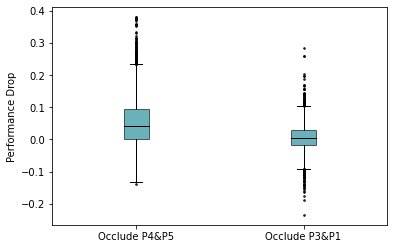

In [46]:
from scipy.stats import mannwhitneyu
print(mannwhitneyu(decrease_big,decrease_small,alternative='greater'))
fig,ax = plt.subplots()
bp = ax.boxplot([decrease_big[:,0],decrease_small[:,0]],patch_artist=True)
for flier in bp['fliers']:
    flier.set(markersize=1.5)
for box in bp['boxes']:
    box.set(facecolor='#087E8B',alpha=0.6,linewidth=1)
for median in bp['medians']:
    median.set(color='black',linewidth=1)
ax.set_xticklabels(['Occlude P4&P5', 'Occlude P3&P1'])
ax.set_ylabel('Performance Drop')